**Mount Google Drive**

In [17]:
from google.colab import drive
drive.mount('/content/gdrive/', force_remount=True)

Mounted at /content/gdrive/


Change Directory to Working Directory

In [18]:
import os
os.chdir('/content/gdrive/My Drive/132A/Project')
!ls

 16QAM		     LLRs_4QAM_10.png   loss_16QAM_15.png   loss_BPSK_20.png
 4QAM		     LLRs_4QAM_15.png   loss_4QAM_10.png    Mixed
 BPSK		     LLRs_4QAM_20.png   loss_4QAM_15.png    Parameters.gsheet
'BPSK Trash Data'    LLRs_BPSK_10.png   loss_4QAM_20.png    Plots
 LLRs_16QAM_10.png   LLRs_BPSK_15.png   loss_BPSK_10.png
 LLRs_16QAM_15.png   LLRs_BPSK_20.png   loss_BPSK_15.png


**Load and Preprocess MATLAB Data** 


In [0]:
import numpy as np
import pandas as pd
import scipy.io as sio

def unison_shuffled_copies(a, b, c, d):
    assert (len(a) == len(b)) and (len(a) == len(c)) and (len(b) == len(c)) and (len(a)==len(d))
    p = np.random.permutation(len(a))
    return a[p], b[p], c[p], d[p]

sym_r = []
sym_i = []
LLR0 = []
LLR1 = []
for i in range(4):
  x = sio.loadmat('4QAM/Raw Data/20 dB/4QAM_sym_20_' + str(i+1) + '.mat')
  y0 = sio.loadmat('4QAM/Raw Data/20 dB/4QAM_LLR_b0_20_' + str(i+1) + '.mat')
  y1 = sio.loadmat('4QAM/Raw Data/20 dB/4QAM_LLR_b1_20_' + str(i+1) + '.mat')
  x_d = x['z_4QAM']
  LLR_b0 = y0['LLR_BPSK_b0']
  LLR_b1= y1['LLR_BPSK_b1']
  sym_r.append(np.asarray(x_d.real.ravel()))
  sym_i.append(np.asarray(x_d.imag.ravel()))
  LLR0.append(np.asarray(LLR_b0.ravel()))
  LLR1.append(np.asarray(LLR_b1.ravel()))
  sym_r[i] = sym_r[i].reshape(1,-1)
  sym_i[i] = sym_i[i].reshape(1,-1)
  LLR0[i] = LLR0[i].reshape(1,-1)
  LLR1[i] = LLR1[i].reshape(1,-1)
  sym_r[i][0], sym_i[i][0], LLR0[i][0], LLR1[i][0] = unison_shuffled_copies(sym_r[i][0], sym_i[i][0], LLR0[i][0], LLR1[i][0])


**Neural Network Model Definition**

In [0]:
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Input, Concatenate, BatchNormalization, Activation
from keras import optimizers
from keras.regularizers import l1

def llr_model():
    Nsym = 10000
    input1 = Input(shape=(Nsym, ))
    input2 = Input(shape=(Nsym, ))
    merged = Concatenate(axis=1)([input1, input2])

    dense1 = Dense(4096, kernel_initializer='truncated_normal', activation = 'relu')(merged)
    dropout1 = Dropout(0.1)(dense1)
    
    dense2 = Dense(2048, kernel_initializer='truncated_normal', activation = 'relu')(dropout1)
    dropout2 = Dropout(0.2)(dense2)

    dense3 = Dense(1024, kernel_initializer='truncated_normal', activation = 'relu')(dropout2)
    dropout3 = Dropout(0.2)(dense3)

    dense4 = Dense(512, kernel_initializer='truncated_normal', activation = 'relu')(dropout3)
    dropout4 = Dropout(0.4)(dense4)

    dense5 = Dense(256, kernel_initializer='truncated_normal', activation = 'relu')(dropout4)
    dropout5 = Dropout(0.6)(dense5)

    output0 = Dense(10000, kernel_initializer='truncated_normal', activation = 'linear')(dropout5)
    output1 = Dense(10000, kernel_initializer='truncated_normal', activation = 'linear')(dropout5)

    model = Model(inputs=[input1, input2], output = [output0, output1])
  
    Adam = optimizers.Adam(lr=1.0, beta_1=0.9, beta_2=0.999, decay=0.99, amsgrad=False)
    model.compile(loss="mean_squared_logarithmic_error", optimizer = 'Adam', metrics = ["mean_squared_error"], target_tensors = None)
    
    return model

#print(model.metrics_names)

**Train and Evaluate Neural Network Model**

In [21]:
import keras
import matplotlib.pyplot as plt

batchsize = 2**7  # training batch size
model = llr_model()

print (model.summary())
history = model.fit([sym_r[0], sym_i[0]], [LLR0[0], LLR1[0]], batch_size=batchsize, epochs = 500, validation_data = ([sym_r[1], sym_i[1]], [LLR0[1], LLR1[1]]), shuffle=True)

# Show performance
score = model.evaluate([sym_r[2], sym_i[2]], [LLR0[2], LLR1[2]], steps = batchsize)
print(score)

fig = plt.figure()
plt.title('Training performance')
plt.plot(history.epoch, history.history['loss'], label='train loss+error')
plt.legend()
fig.savefig("4QAM/loss_4QAM_20.png")
plt.close(fig)

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            (None, 10000)        0                                            
__________________________________________________________________________________________________
input_6 (InputLayer)            (None, 10000)        0                                            
__________________________________________________________________________________________________
concatenate_3 (Concatenate)     (None, 20000)        0           input_5[0][0]                    
                                                                 input_6[0][0]                    
__________________________________________________________________________________________________
dense_15 (Dense)                (None, 4096)         81924096    concatenate_3[0][0]        

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:30: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=[<tf.Tenso..., outputs=[<tf.Tenso...)`


Train on 1 samples, validate on 1 samples
Epoch 1/500
1/1 [==============================] - 3s 3s/step - loss: 27.9220 - dense_20_loss: 14.0828 - dense_21_loss: 13.8393 - dense_20_mean_squared_error: 160615.8906 - dense_21_mean_squared_error: 160595.2969 - val_loss: 28.4054 - val_dense_20_loss: 14.2173 - val_dense_21_loss: 14.1882 - val_dense_20_mean_squared_error: 160984.8906 - val_dense_21_mean_squared_error: 160616.4688
Epoch 2/500
1/1 [==============================] - 0s 120ms/step - loss: 28.3520 - dense_20_loss: 14.1904 - dense_21_loss: 14.1615 - dense_20_mean_squared_error: 170055.3125 - dense_21_mean_squared_error: 169748.3594 - val_loss: 28.2145 - val_dense_20_loss: 14.1325 - val_dense_21_loss: 14.0820 - val_dense_20_mean_squared_error: 160992.1719 - val_dense_21_mean_squared_error: 160651.0469
Epoch 3/500
1/1 [==============================] - 0s 119ms/step - loss: 30.0491 - dense_20_loss: 14.9977 - dense_21_loss: 15.0514 - dense_20_mean_squared_error: 195680.9375 - dense_2

**Plot True and NN LLRs**

1/1 [==============================] - 0s 158ms/step
[-253.29651  308.78018 -308.29086 ...  353.84525  365.59613  339.58167]
[ 333.93945  301.75403  355.71844 ...  350.0171  -181.60799 -245.26434]


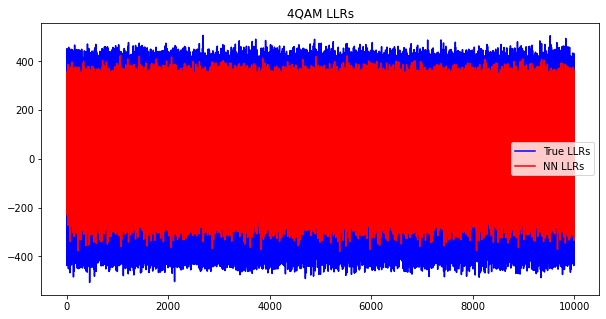

In [22]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(10,5))
pred_llrs0, pred_llrs1 = model.predict([sym_r[3], sym_i[3]], verbose = 1, batch_size = None)
print (pred_llrs0[0])
print (pred_llrs1[0])
plt.plot(LLR1[3][0],'b', label = 'True LLRs',zorder=2)
plt.plot(pred_llrs1[0],'r', label = 'NN LLRs',zorder=3)
plt.title('4QAM LLRs')
plt.legend()
plt.show()
fig.savefig("4QAM/LLRs_4QAM_20.png")

**Plot LLRs of Bit #0**

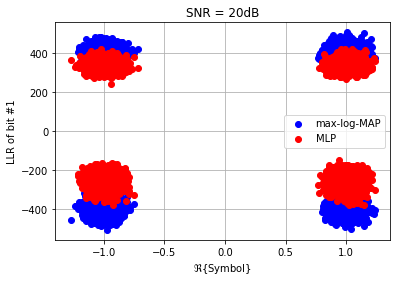

[-253.29651  308.78018 -308.29086 ...  353.84525  365.59613  339.58167]


In [23]:
fig2 = plt.figure()
plt.grid(True)
plt.scatter(sym_r[3], LLR1[3], c='b', label = 'max-log-MAP',zorder=2)
plt.scatter(sym_r[3], pred_llrs1[0], c='r', label = 'MLP',zorder=3)
plt.ylabel('LLR of bit #1')
plt.xlabel(r'$\Re$' + '{Symbol}')
plt.title('SNR = 20dB')
plt.legend()
fig2.savefig("Plots/4QAM_LLR_b1_20.png")
plt.show()
print (pred_llrs0[0])

**Plot LLRs of Bit #1**


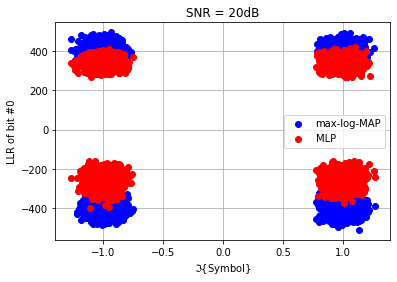

[-253.29651  308.78018 -308.29086 ...  353.84525  365.59613  339.58167]


In [24]:
fig3 = plt.figure()
plt.grid(True)
plt.scatter(sym_i[3], LLR0[3], c='b', label = 'max-log-MAP',zorder=2)
plt.scatter(sym_i[3], pred_llrs0[0], c='r', label = 'MLP',zorder=3)
plt.ylabel('LLR of bit #0')
plt.xlabel(r'$\Im$' + '{Symbol}')
plt.title('SNR = 20dB')
plt.legend()
fig3.savefig("Plots/4QAM_LLR_b0_20.png")
plt.show()
print (pred_llrs0[0])